# Шаг 1. Импортируем необходимые библиотеки и загрузим данные. 

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv('C://Users//Igor//Desktop//data_analyst//7 project//gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


#  Шаг 2. Проведем исследовательский анализ  данных (EDA)

### 2.1 Изучим средние значения показателей для ушедших и не ушедших клиентов.

In [4]:
df.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


### 2.2 Построим гистограммы и распределния для ушедших и не ушедших клиентов

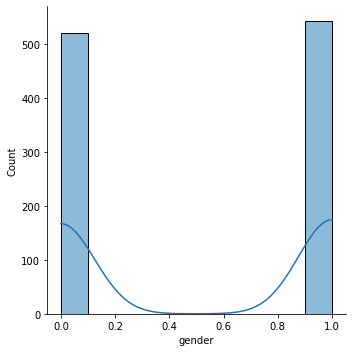

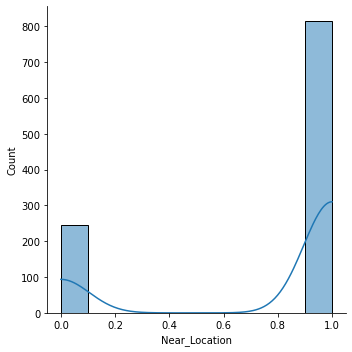

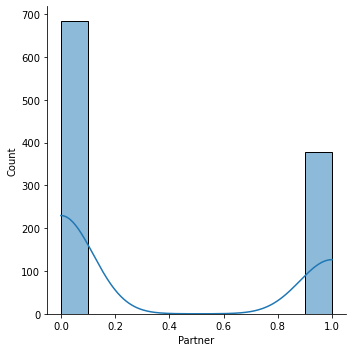

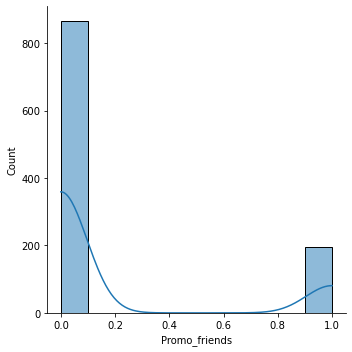

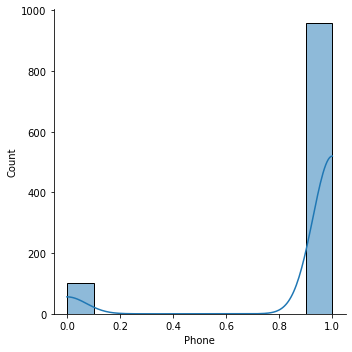

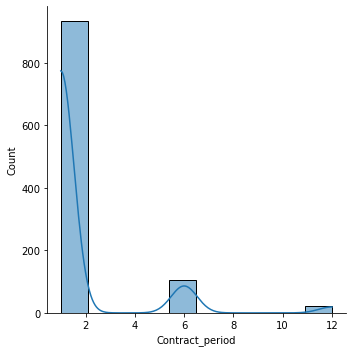

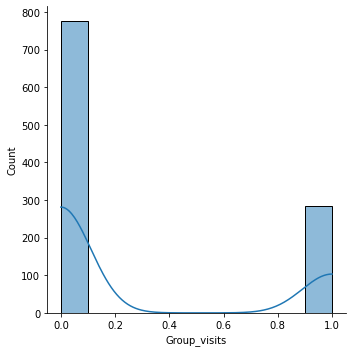

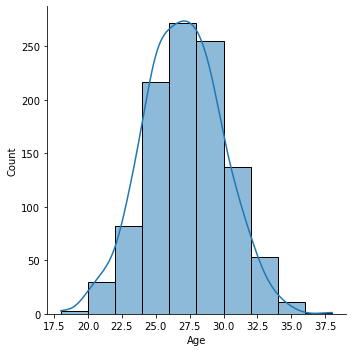

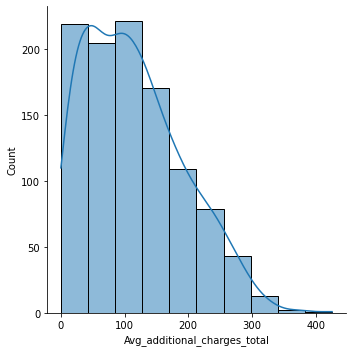

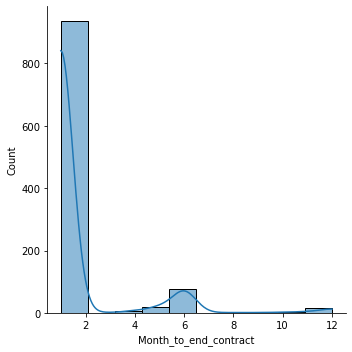

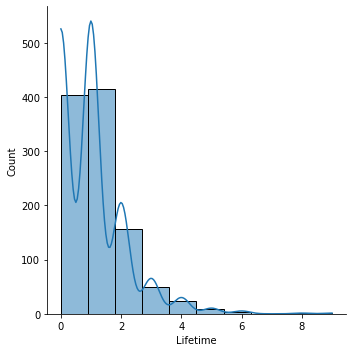

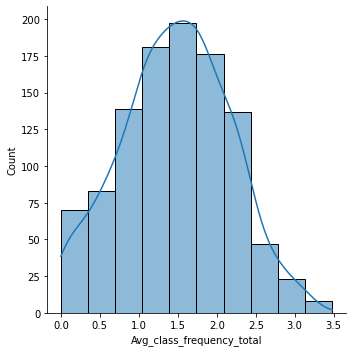

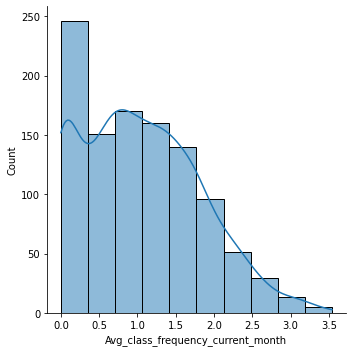

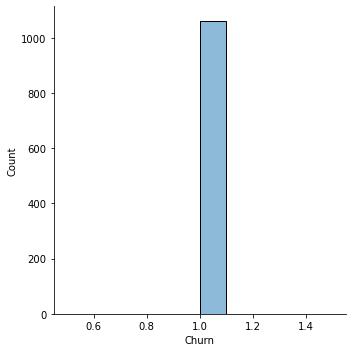

In [5]:
# Ушедшие клиенты
for feature in df.columns:
    sns.displot(df[df['Churn']==1][feature], bins=10,kde=True)
    plt.show() 

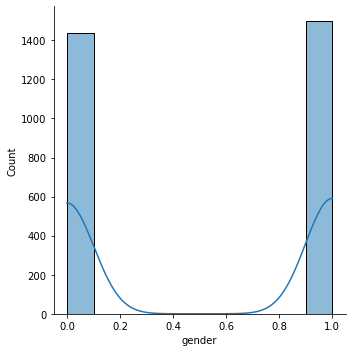

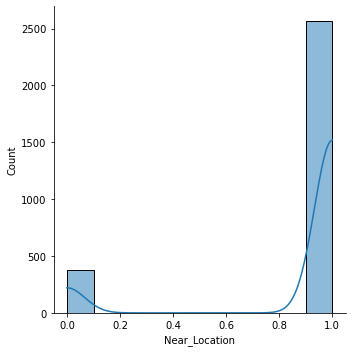

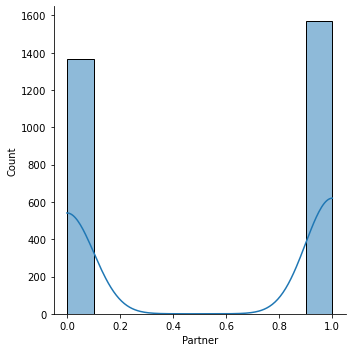

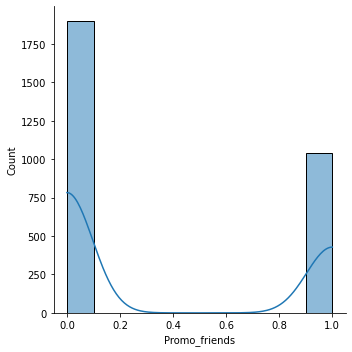

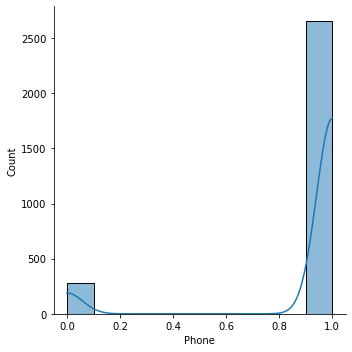

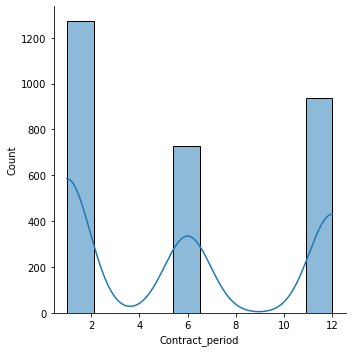

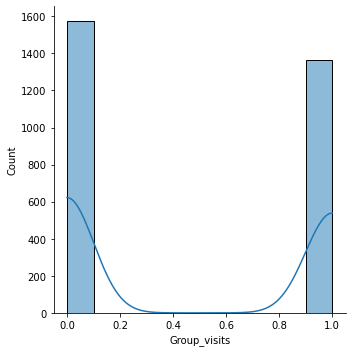

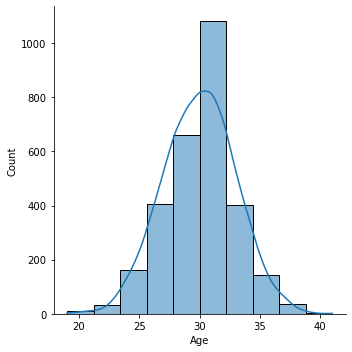

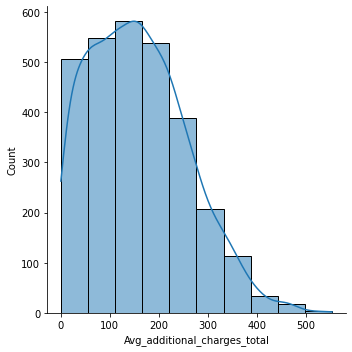

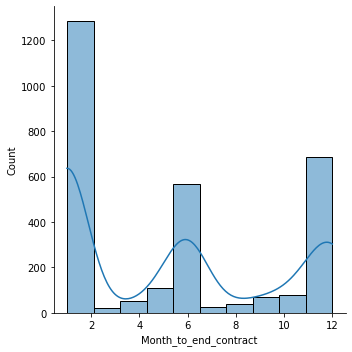

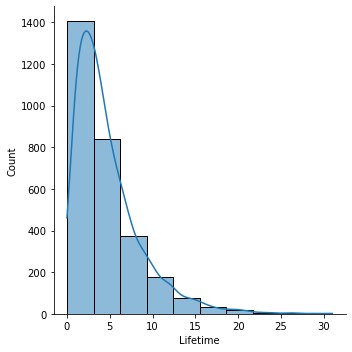

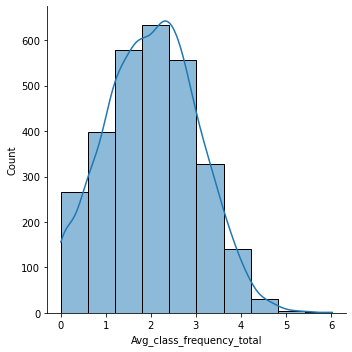

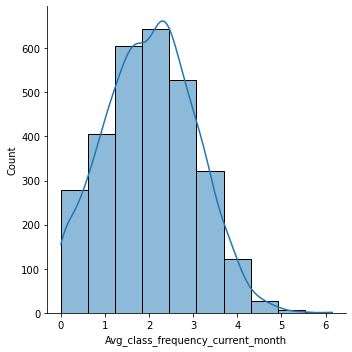

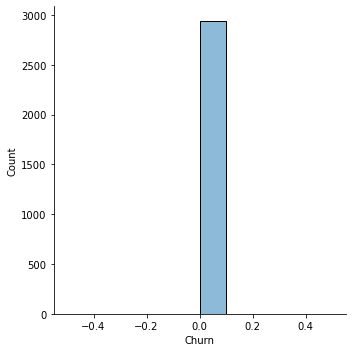

In [6]:
# Не ушедшие клиенты
for feature in df.columns:
    sns.displot(df[df['Churn']==0][feature], bins=10,kde=True)
    plt.show() 

### 2.3 Построим матрицу корреляций признаков для всех клиентов 

<AxesSubplot:>

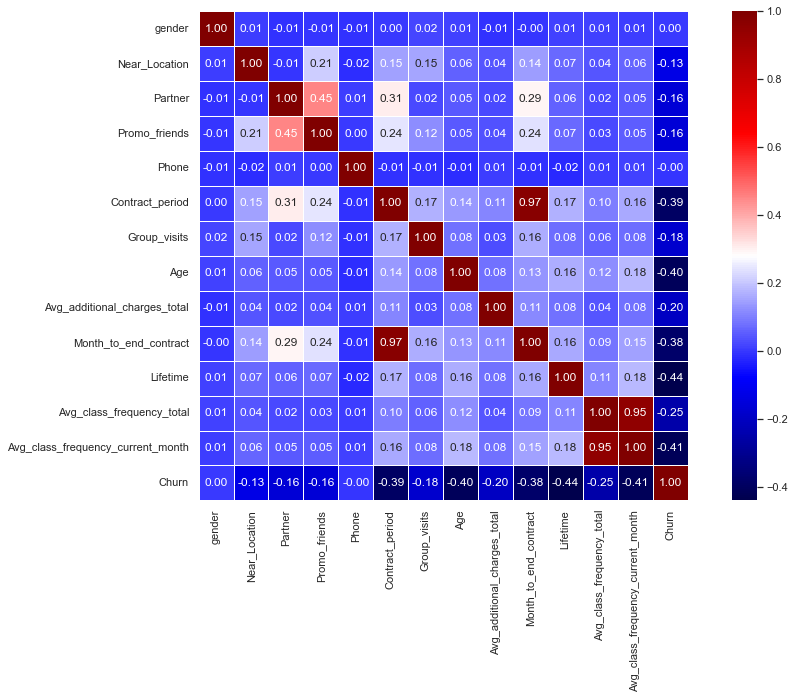

In [7]:
sns.set(rc={'figure.figsize':(16,9)})
sns.heatmap(df.corr(), square=True, annot=True, fmt = '0.2f', linewidths=.5, cmap="seismic")

## Вывод по EDA
По изученым графикам замечаем, что клиентов которые живут далеко от фитнес клуба больше среди ушедших. Также видим различие в отсутсвии партнерской программы и программы "Приведи друга" у ушедших, маленький срок действия абонемента (1 месяц), редкое посещение групповых занятий, остаток месяцев абонемента 1 месяц, среднее количество посещений в неделю за предыдущий месяц упало. По средним значениям показателей видим разницу практически по всем признакам, за исключением наличия номера телефона клиента и пола. По матрице корреляций замечаем большую корреляцию между признаками среднего посещения за весь переод и среднего посещения за прошлый месяц, но по графикам было видно что для ушедших клиентов корреляция будет другой. Так же высокая корреляция между длительносью абонемента и количеством месяцев до окончяния абонемента, что логично. 



# Шаг 3. Построим модель прогнозирования оттока клиентов

### 3.1 Разобьем данные на обучающую и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis = 1), df['Churn'], test_size = 0.2)

In [10]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### 3.2 Обучим модель на train-выборке двумя способами

In [11]:
model_logisticRegression = LogisticRegression()
model_logisticRegression.fit(X_train_st, y_train)
predict_logisticRegression = model_logisticRegression.predict(X_test_st)

In [16]:
model_tree = RandomForestClassifier()
model_tree.fit(X_train_st, y_train)
predict_tree = model_tree.predict(X_test_st)

### 3.3 Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [17]:
def metrics(predict):
    print('accuracy={}'.format(accuracy_score(y_test, predict)))
    print('precision={}'.format(precision_score(y_test, predict)))
    print('recall={}'.format(recall_score(y_test, predict)))
    

In [18]:
metrics(predict_logisticRegression)

accuracy=0.95
precision=0.9137055837563451
recall=0.8866995073891626


In [19]:
metrics(predict_tree)

accuracy=0.935
precision=0.8952879581151832
recall=0.8423645320197044


Вывод: метод логистической регрессии показал себя немного лучше чем метод случайного леса. Доля правильных ответов 95%, Точность 91%, полнота 89%.

# Шаг 4. Проведем кластеризацию клиентов

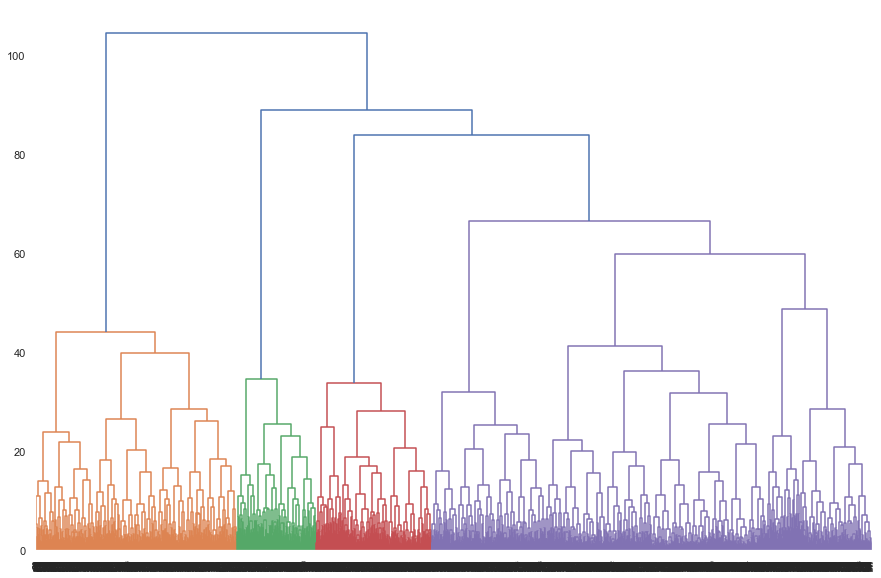

In [33]:
X_st = scaler.fit_transform(df.drop('Churn', axis = 1))
linked = linkage(X_st, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

In [57]:
km = KMeans(n_clusters=4)
labels = km.fit_predict(X_st)
df_labels = pd.DataFrame(labels)
df_labels.columns = ['label']
df_labels.value_counts()

label
2        1477
3        1082
1        1055
0         386
dtype: int64

In [58]:
df = df.join(df_labels, how='left')

In [63]:
df.groupby('label').mean().T

label,0,1,2,3
gender,0.523316,0.542180,0.488829,0.503697
Near_Location,0.862694,0.865403,0.756263,0.940850
Partner,0.471503,0.336493,0.384563,0.778189
Promo_friends,0.305699,0.200000,0.192282,0.573937
Phone,0.000000,1.000000,1.000000,1.000000
Contract_period,4.777202,2.391469,1.897089,10.680222
Group_visits,0.427461,0.449289,0.292485,0.534196
Age,29.297927,30.010427,28.035884,29.905730
Avg_additional_charges_total,144.208179,157.933002,129.485762,161.035828
Month_to_end_contract,4.466321,2.227488,1.804333,9.752311


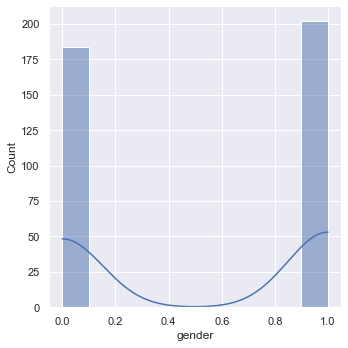

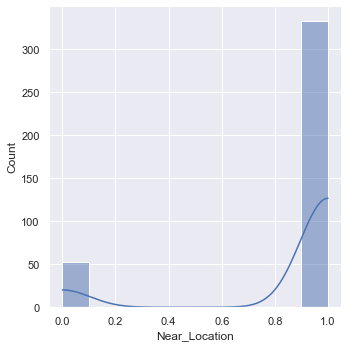

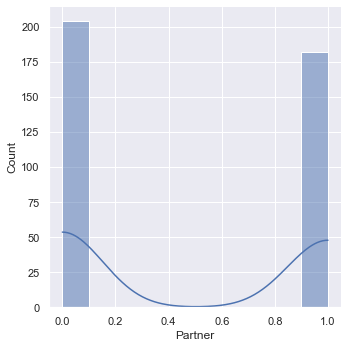

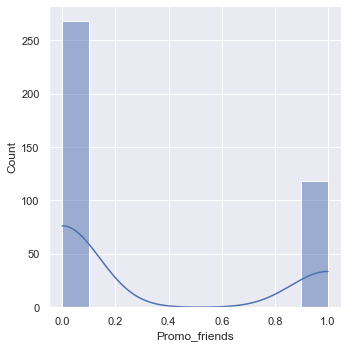

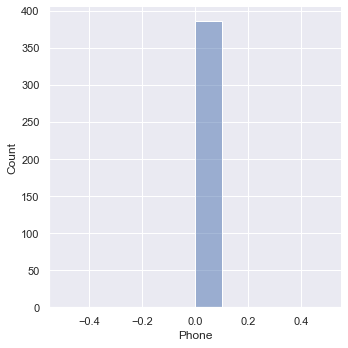

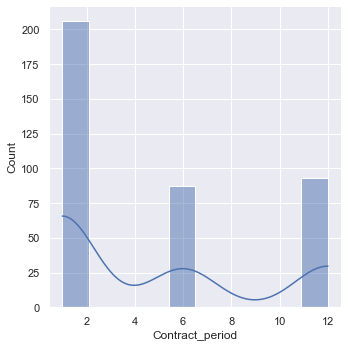

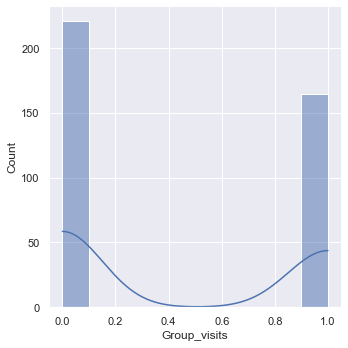

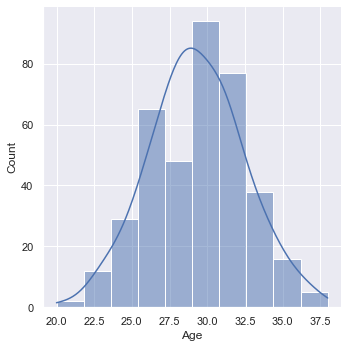

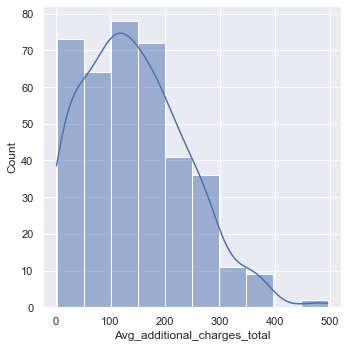

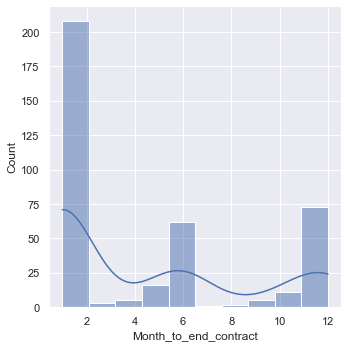

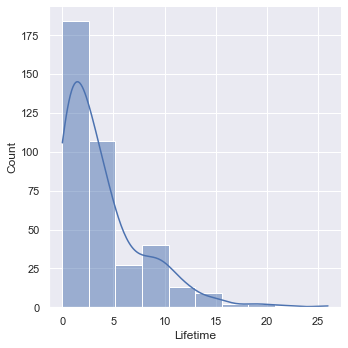

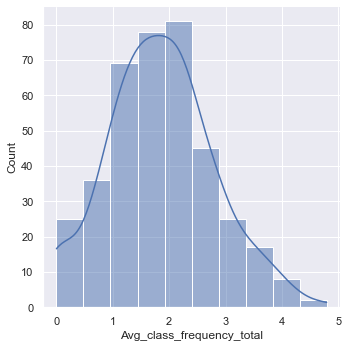

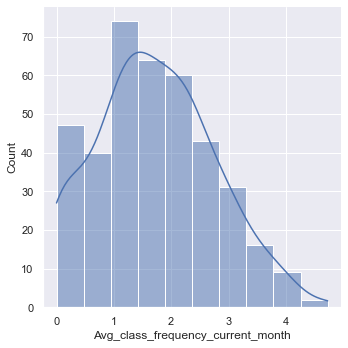

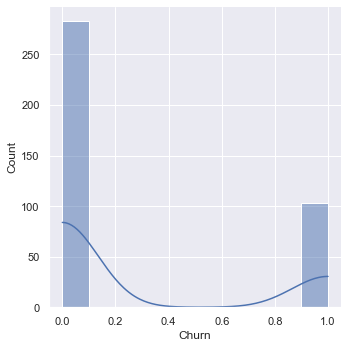

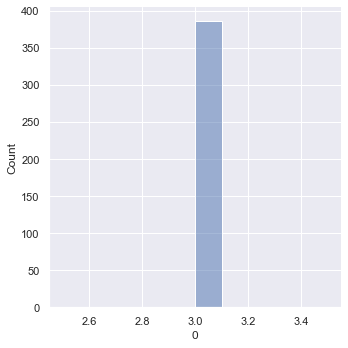

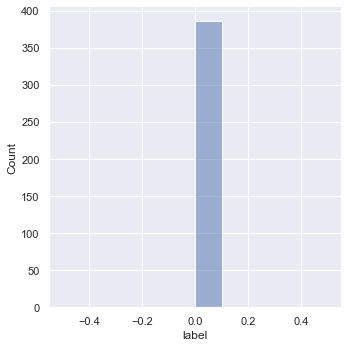

In [65]:
for feature in df.columns:
    sns.displot(df[df['label']==0][feature], bins=10,kde=True)
    plt.show() 

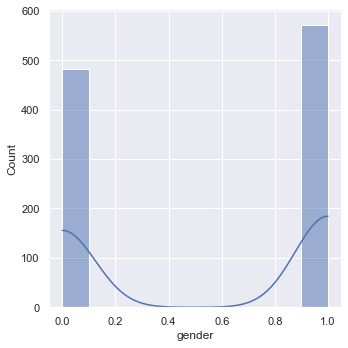

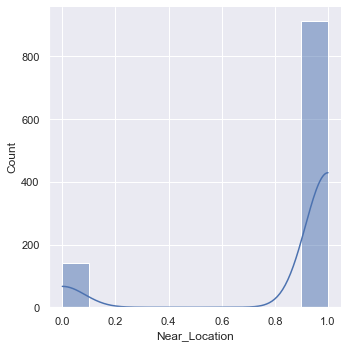

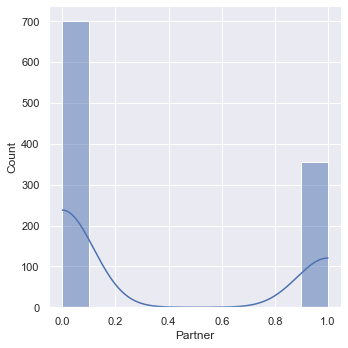

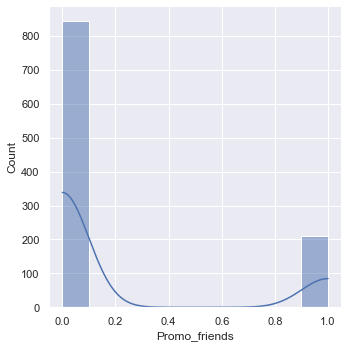

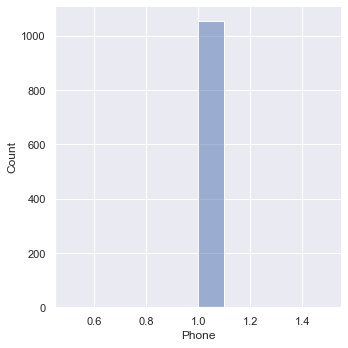

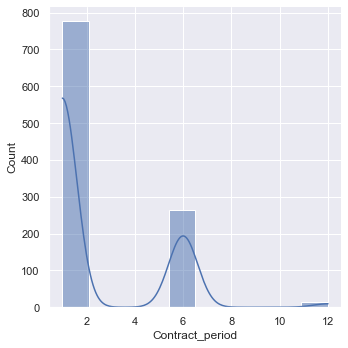

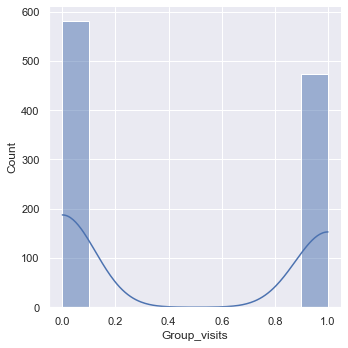

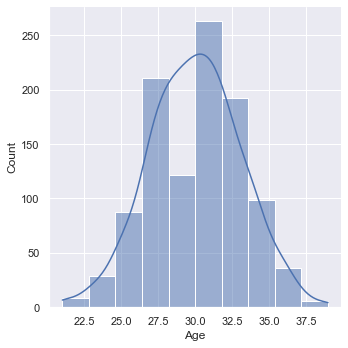

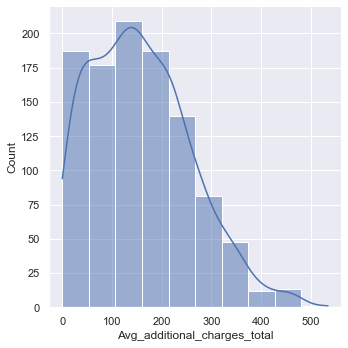

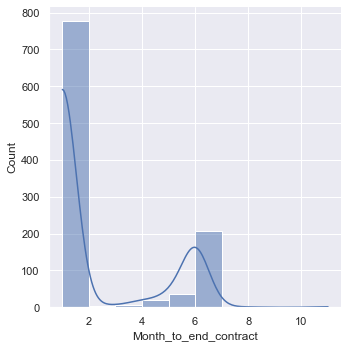

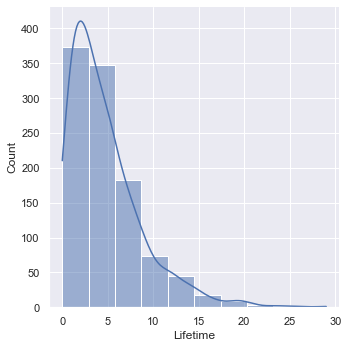

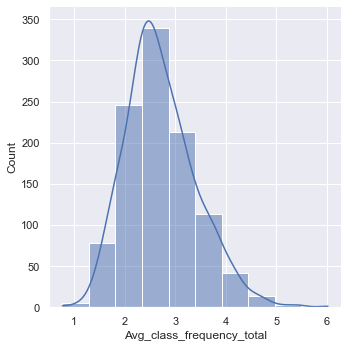

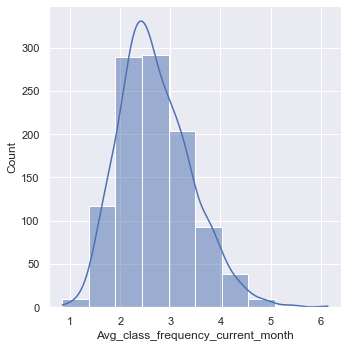

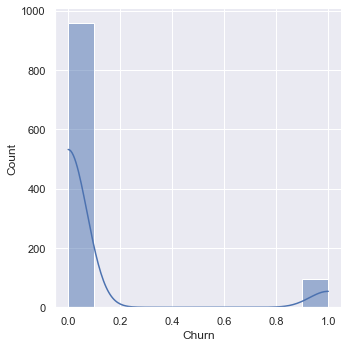

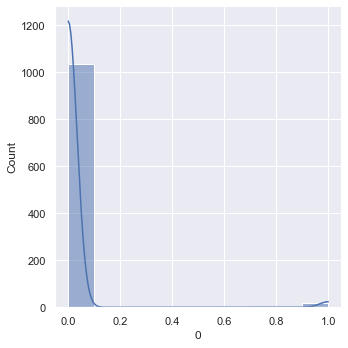

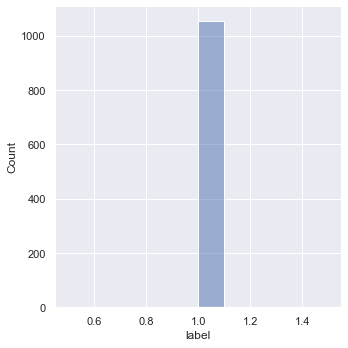

In [66]:
for feature in df.columns:
    sns.displot(df[df['label']==1][feature], bins=10,kde=True)
    plt.show() 

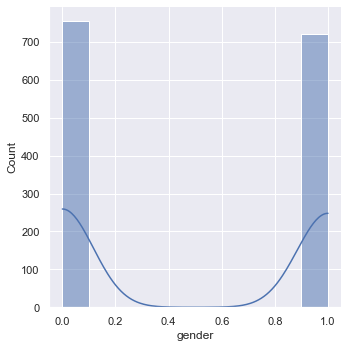

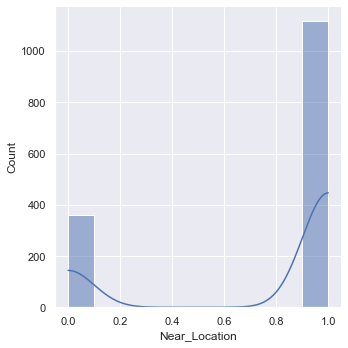

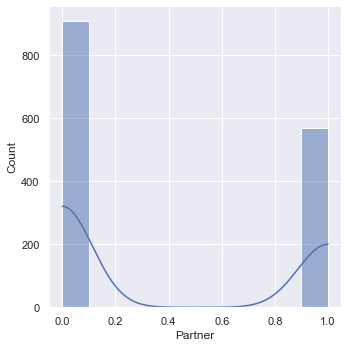

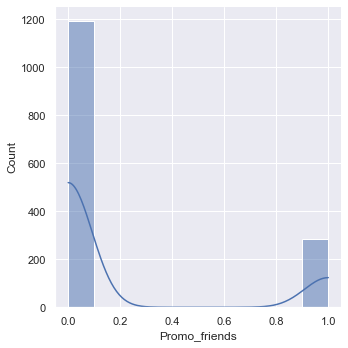

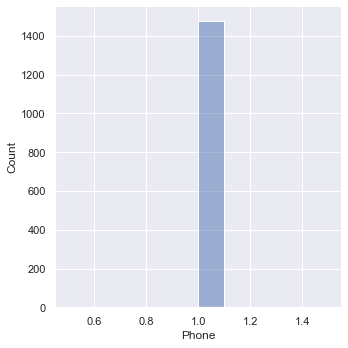

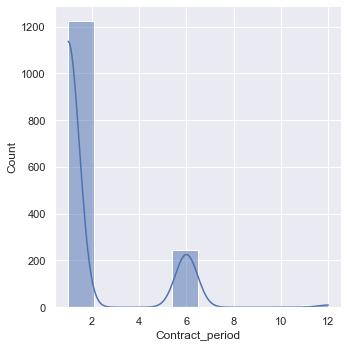

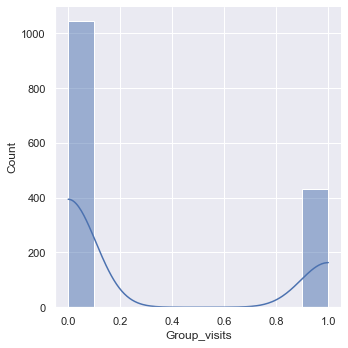

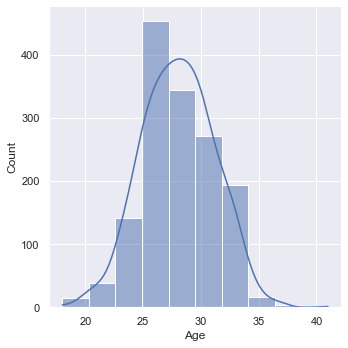

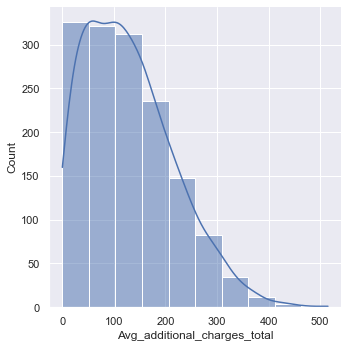

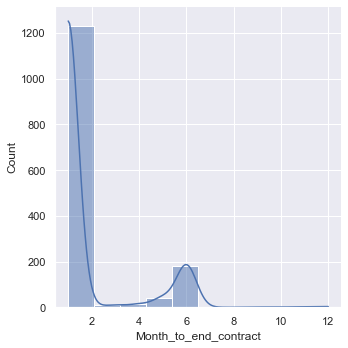

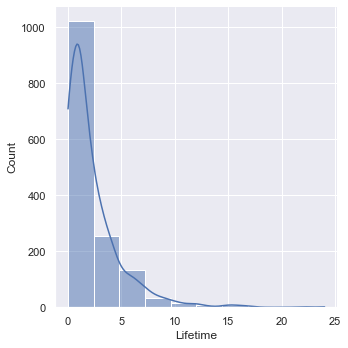

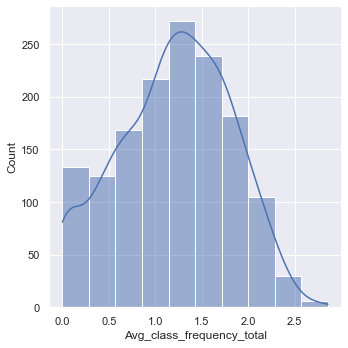

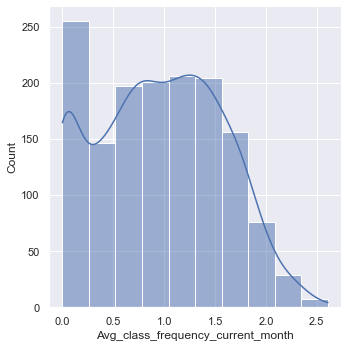

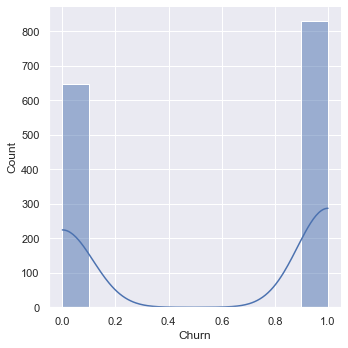

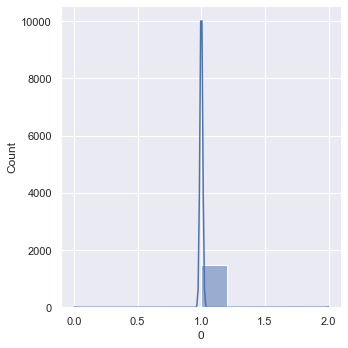

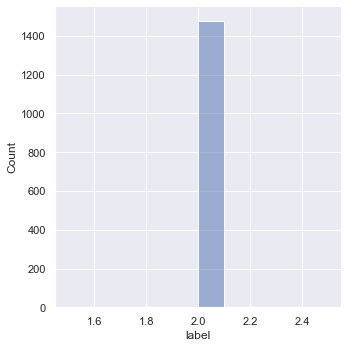

In [67]:
for feature in df.columns:
    sns.displot(df[df['label']==2][feature], bins=10,kde=True)
    plt.show() 

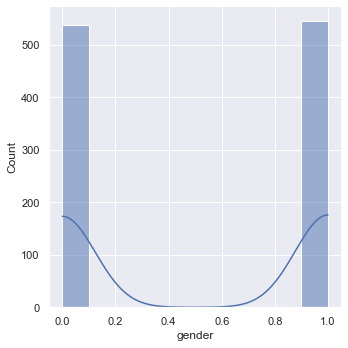

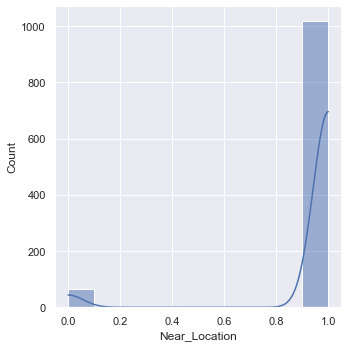

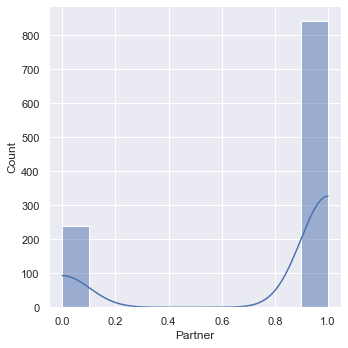

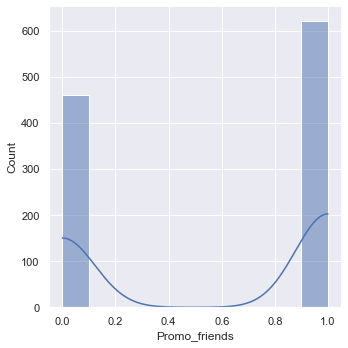

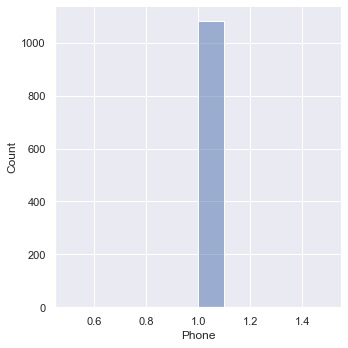

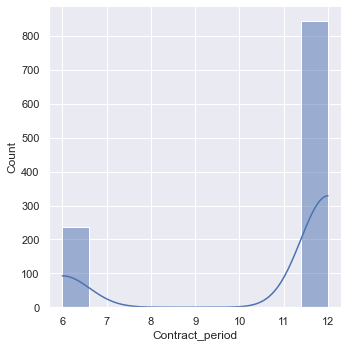

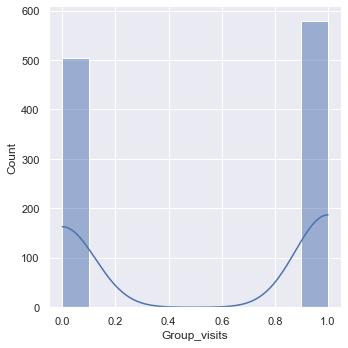

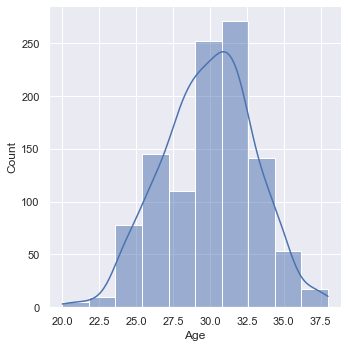

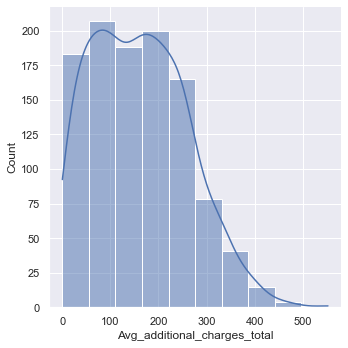

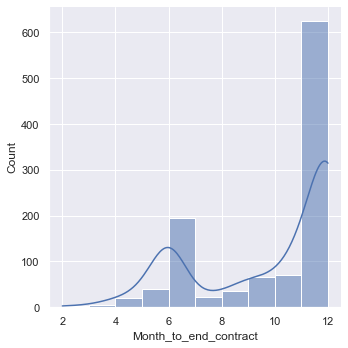

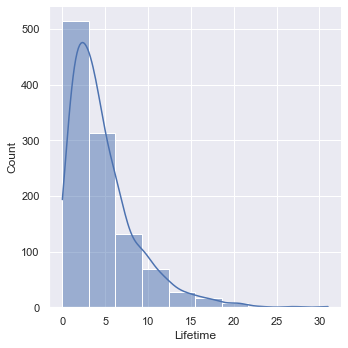

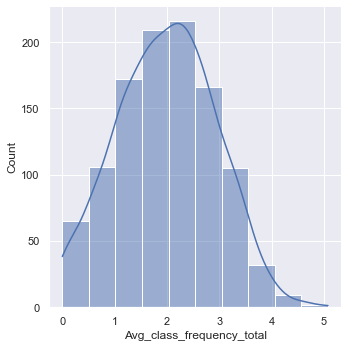

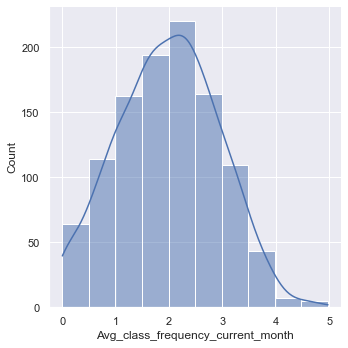

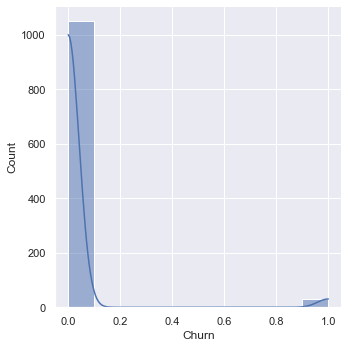

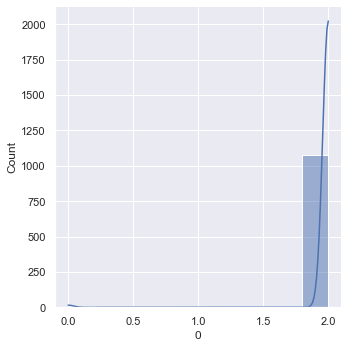

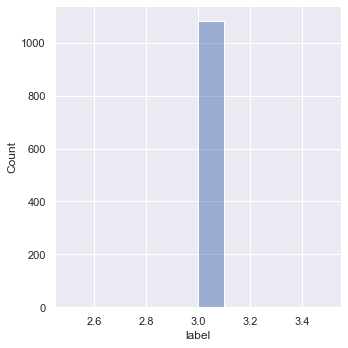

In [68]:
for feature in df.columns:
    sns.displot(df[df['label']==3][feature], bins=10,kde=True)
    plt.show() 

In [69]:
df.groupby('label')['Churn'].mean()

label
0    0.266839
1    0.091943
2    0.561273
3    0.029575
Name: Churn, dtype: float64

Вывод: по средним значениям признаков и по графикам видим, что кластеры между собой отличаются значенями признаков, в каких то более хорошие значения, в каких то менее. Построив долю оттока для каждой группы, видим четкое разделение  по оттоку. Есть группа с самым большим оттоком 56% и группа с самым маленьким 3%. Так же есть средние значения - 9% и 26%

# Шаг 5. Выводы

#### Проанализируем группу клиентов с самым большим оттоком: 
1. Самая большая доля живущих далеко от фитнес клуба 
2. Мало партнерских программ
3. Меньше всех акций "Пригласи друга"
4. Самый маленький срок абонементов
5. Меньше всего посещений групповых занятий
6. Самый молодой средний возраст
7. Меньше всего дополнительных трат
8. Самое маленькое время жизни
9. Меньше всего посещений в неделю за весь период и за предыдущий месяц

#### Обратные выводы можно сделать и для группы клиентов с самым маленьким оттоком. 



#### Для удержания клиентов из "группы риска" можно предпринять некоторые маркетинговые действия. 

Из средрних показателей видно, что самые трудноудерживаемые клиенты - люди более молодого возраста, которые менее платежеспособные, менее социально-активные (не пользуются существующими акциями, не используют групповые занятия), а так же дальнеживущие. Можно порекомендовать запустить специальные акции для таких групп клиентов, например: 
1. Скидочная программа для студентов, либо до определенного возраста.
2. Абонемент с ограниченым функционалом фитнес клуба (без групповых занятий) по более низкой цене.
3. Скидочная программа при покупке абноменета на длительный срок, например при покупке абонемента на 12 месяцев - скидка 10%.
4. Можно придумать систему поощрений при регулярном посещении фитнес клуба (например если клиент на протяжении 4 недель ходил мнимум 3 раза в неделю - дарить 1 бесплатное индивидуальное занятие с тренером)